In [1]:
%%capture
!pip install scprep
!pip install anndata
!pip install scanpy

In [2]:
import numpy as np
import pandas as pd
import anndata
import scprep
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
import tempfile
import os
import inspect
import sys
import scipy
from scipy import sparse

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import load_raw
import normalize_tools as nm
import metrics

# **try out with scicar cell lines dataset**

**1. URLs for raw data**

In [3]:
rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes = load_raw.load_raw_cell_lines()

 **2. select the joint sub-datasets and store them into csv files**

In [4]:
scicar_data, joint_index, keep_cells_idx = load_raw.merge_data(rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes)
#rna_df, atac_df = ann2df(scicar_data)

In [5]:
print(scicar_data)

AnnData object with n_obs × n_vars = 4739 × 60550
    obs: 'cell_name', 'experiment', 'treatment_time', 'source', 'group'
    var: 'gene_type', 'gene_short_name', 'n_counts'
    uns: 'mode2_obs', 'mode2_var', 'mode2_varnames', 'mode2_var_id', 'mode2_var_chr', 'mode2_var_start', 'mode2_var_end'
    obsm: 'mode2'


In [6]:
test_scicar_data = load_raw.subset_joint_data(scicar_data)

# **Procrustes**

In [7]:
def procrustes(adata, n_svd=100):
    n_svd = min([n_svd, min(adata.X.shape)-1, min(adata.obsm["mode2"].shape)-1])
    nm.log_cpm(adata)
    nm.log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.X)
    Y_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.obsm["mode2"])
    X_proc, Y_proc, _ = scipy.spatial.procrustes(X_pca, Y_pca)
    adata.obsm["aligned"] = X_proc
    adata.obsm["mode2_aligned"] = Y_proc
    return adata

In [8]:
def procrustes_split(train_data, test_data, n_svd=100):
    n_svd = min([n_svd, min(train_data.X.shape)-1, min(train_data.obsm["mode2"].shape)-1])
    nm.log_cpm(train_data)
    nm.log_cpm(train_data, obsm="mode2", obs="mode2_obs", var="mode2_var")
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit(train_data.X).transform(test_data.X)
    Y_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit(train_data.obsm["mode2"]).transform(test_data.obsm["mode2"])
    
    X_proc, Y_proc, _ = scipy.spatial.procrustes(X_pca, Y_pca)
    test_data.obsm["aligned"] = X_proc
    test_data.obsm["mode2_aligned"] = Y_proc
    return test_data

# **Harmonic Alignment**

In [26]:
!pip install --user git+https://github.com/KrishnaswamyLab/harmonic-alignment#subdirectory=python

  Cloning https://github.com/KrishnaswamyLab/harmonic-alignment to /tmp/pip-req-build-3axcu8k6
     |████████████████████████████████| 1.8 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 28.6 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 6.3 MB/s  eta 0:00:01
  Created wheel for harmonicalignment: filename=harmonicalignment-0.0-py3-none-any.whl size=16722 sha256=3c5fb8372c716d41d90a0c00b66d8a3085ec342105ecaffd249f4d87fbdb3164
  Stored in directory: /tmp/pip-ephem-wheel-cache-367mq9vl/wheels/cb/4a/4d/f8801b90905a457232c488d735da80d7008965523569950d3f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=67e37eb62a5180a1f89eef4ab90d7c5e4dba758bd2d8546ce5b4d76b69279a0e
  Stored in directory: /home/jiayueg/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-linux_x86_64.whl size=72381 sha256=4069946d84ab0845ece5ce54f33e9e337eb24245bd2

In [1]:
import harmonicalignment

In [25]:
#sqrt CPM version

def harmonic_alignment_sqrt_cpm(adata, n_eigenvectors=100, n_svd=100, n_pca_XY=100):
    sqrt_cpm(adata)
    log_cpm(adata)
    n_svd = min([n_svd, min(adata.X.shape)-1, min(adata.obsm["mode2"].shape)-1])
    if adata.X.shape[0] <= n_eigenvectors:
        n_eigenvectors = None
    if adata.X.shape[0] <= n_pca_XY:
        n_pca_XY = None
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.X)
    Y_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.obsm["mode2"])
    ha_op = harmonicalignment.HarmonicAlignment(
        n_filters=8, n_pca_XY=n_pca_XY, n_eigenvectors=n_eigenvectors
    )
    ha_op.align(X_pca, Y_pca)
    XY_aligned = ha_op.diffusion_map(n_eigenvectors=n_eigenvectors)
    adata.obsm["aligned"] = XY_aligned[: X_pca.shape[0]]
    adata.obsm["mode2_aligned"] = XY_aligned[X_pca.shape[0] :]
    return adata

# **Scot Alignment**

In [26]:
!git clone https://github.com/rsinghlab/SCOT.git

Cloning into 'SCOT'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 934 (delta 108), reused 115 (delta 52), pack-reused 746
Receiving objects: 100% (934/934), 110.15 MiB | 41.75 MiB/s, done.
Resolving deltas: 100% (473/473), done.
Checking out files: 100% (86/86), done.


In [27]:
!pip install POT
!pip install matlab
!pip install cython

     |████████████████████████████████| 455 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 97.4 MB/s eta 0:00:01
  Created wheel for matlab: filename=matlab-0.1-py3-none-any.whl size=1179 sha256=769cae883ffcfe6630f0c62890dc8459a19b1ac94cf00a093d274e274a827917
  Stored in directory: /home/jiayueg/.cache/pip/wheels/9d/e3/ca/f9444a09793775674f6d6c3389b6192c72eff2503085389009
Successfully built matlab


In [28]:
sys.path.insert(1, "./SCOT/src")
import scot2
from scot2 import SCOT

In [29]:
def _scot(adata, n_svd=100, balanced=False):
    n_svd = min(n_svd, min(adata.X.shape)-1, min(adata.obsm["mode2"].shape)-1)
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.X)
    Y_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.obsm["mode2"])
  
    scot_new = SCOT(X_pca, Y_pca)
    x_new_unbal, y_new_unbal = scot_new.align(
        k=50, e=1e-3, rho=0.0005, normalize=True, balanced=balanced
    )
    adata.obsm["aligned"] = np.array(x_new_unbal).squeeze()
    adata.obsm["mode2_aligned"] = np.array(y_new_unbal).squeeze()
    return adata

In [30]:
#unbalanced method produces NaN for some reasons
def scot_sqrt_cpm_unbalanced(adata, n_svd=100, balanced=False):
    sqrt_cpm(adata)
    log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    _scot(adata, n_svd=n_svd, balanced=balanced)
    return adata

def scot_sqrt_cpm_balanced(adata, n_svd=100, balanced=True):
    sqrt_cpm(adata)
    log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    _scot(adata, n_svd=n_svd, balanced=balanced)
    return adata

# **Store Scicar Dataset to h5ad File**

In [23]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
scicar_data.write_h5ad("/gdrive/My Drive/scicar_data.h5ad")

... storing 'cell_name' as categorical
... storing 'experiment' as categorical
... storing 'source' as categorical
... storing 'group' as categorical
... storing 'gene_type' as categorical
... storing 'gene_short_name' as categorical


OSError: ignored

# **MNN**

In [ ]:
#convert R function to a collable py function
_mnn = r_function("/gdrive/My Drive/mnn.R")
#mnn with log_cpm preprocessing

def mnn_log_cpm(adata):
    log_cpm(adata)
    log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    return _mnn(adata)
  
#mnn with log_scran preprocessing
def mnn_log_scran_pooling(adata):
    log_scran_pooling(adata)
    log_cpm(adta, obsm="mode2", obs="mode2_obs", var="mode2_var")
    return _mnn(adata)

/gdrive/My Drive/mnn.R


In [31]:
%%capture
test_scicar_data = subset_joint_data(scicar_data)
test_scicar_data = mnn_log_scran_pooling(test_scicar_data)
#knn_auc(test_scicar_data)

NameError: name 'mnn_log_scran_pooling' is not defined

# **alignment score for procrustes**

In [9]:
def plot_procrustes_knn(params_range, train=True):
    test_scicar_data = load_raw.subset_joint_data(scicar_data, n_cells = 1500)
    train_data, test_data = load_raw.train_test_split(sub_scicar_data, train_prop = 0.5)
    knn_scores = [0.0] * len(params_range)
    for i, n_svd in enumerate(params_range):
        if train:
            procrustes(train_data, n_svd = n_svd)
            knn_score = metrics.knn_auc(train_data, n_svd = n_svd)
        else:
            procrustes_split(train_data, test_data, n_svd = n_svd)
            knn_score = metrics.knn_auc(test_data, n_svd = n_svd)
        knn_scores[i] = knn_score
    plt.xlabel("n_svd")
    plt.ylabel("knn score")
    plt.plot(params_range, knn_scores)
    plt.show()

0.3497140961366616
0.6901419629584501
0.4205210710964249
0.6863575607344916


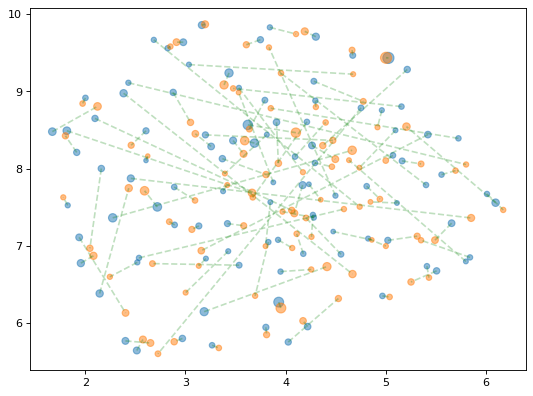

In [ ]:
sub_scicar_data = load_raw.subset_joint_data(scicar_data, n_cells = 1500)
train_data, test_data = load_raw.train_test_split(sub_scicar_data, train_prop = 0.5)
procrustes_split(train_data, test_data, n_svd = 150)
procrustes(train_data, n_svd = 150)
print(metrics.knn_auc(test_data, n_svd=150))
print(metrics.mse(test_data))
print(metrics.knn_auc(train_data, n_svd=150))
print(metrics.mse(test_data))
metrics.plot_multimodal_umap(train_data, num_points=100, connect_modalities=True)
metrics.plot_multimodal_umap(test_data, num_points=100, connect_modalities=True)

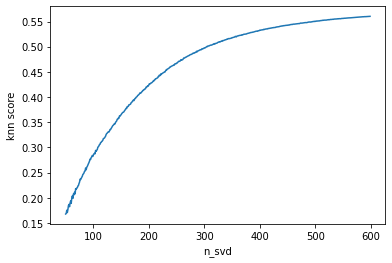

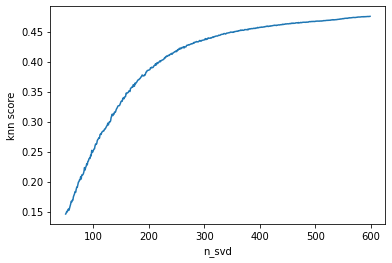

In [17]:
plot_procrustes_knn(range(50, 600))
plot_procrustes_knn(range(50, 600), train=False)

# **alignment score for harmonic alignment**

In [37]:
harmonic_alignment_sqrt_cpm(test_scicar_data)
print(knn_auc(test_scicar_data))
print(mse(test_scicar_data))

/home/jiayueg/.local/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 19 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/jiayueg/.local/lib/python3.8/site-packages/graphtools/graphs.py:451: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


0.09570764011597999
1.0004838277657804


# **alignment score for scot**

In [41]:
test_scicar_data = subset_joint_data(scicar_data)
scot_sqrt_cpm_balanced(test_scicar_data)
print(knn_auc(test_scicar_data))
print(mse(test_scicar_data))

It.  |Err         
-------------------
    0|2.200180e-03|
   10|2.387136e-03|
   20|2.615103e-03|
   30|1.528235e-03|
   40|1.051872e-03|
   50|6.949927e-04|
   60|4.957172e-04|
   70|4.674470e-04|
   80|2.953773e-04|
   90|2.374930e-04|
  100|1.859278e-04|
  110|1.840104e-04|
  120|2.012579e-04|
  130|2.238157e-04|
  140|2.893454e-04|
  150|2.998587e-04|
  160|2.197025e-04|
  170|1.672223e-04|
  180|1.639067e-04|
  190|1.482156e-04|
It.  |Err         
-------------------
  200|7.052841e-05|
  210|4.591526e-05|
  220|4.460609e-05|
  230|5.023429e-05|
  240|5.115160e-05|
  250|4.296058e-05|
  260|3.737661e-05|
  270|3.282929e-05|
  280|2.782190e-05|
  290|2.385722e-05|
  300|2.231126e-05|
  310|2.407502e-05|
  320|3.090345e-05|
  330|4.660831e-05|
  340|7.257048e-05|
  350|9.850706e-05|
  360|1.097518e-04|
  370|3.993829e-05|
  380|2.194712e-05|
  390|1.426638e-05|
It.  |Err         
-------------------
  400|9.812246e-06|
  410|7.076451e-06|
  420|5.326748e-06|
  430|4.160802e-06|
  4

In [42]:
scot_sqrt_cpm_balanced(scicar_data)
print(knn_auc(scicar_data))
print(mse(scicar_data))

It.  |Err         
-------------------
    0|4.355200e-04|
   10|1.522882e-05|
   20|6.121274e-06|
   30|3.386841e-06|
   40|1.255806e-06|
   50|3.897142e-07|
   60|1.144282e-07|
   70|3.306420e-08|
   80|9.510051e-09|
   90|2.731709e-09|
  100|7.843724e-10|
0.16206478180055905
0.5315781392374076
